In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

# Analysis of the effect of being an incumbent

## Data wrangling

### Load all relevant data sets

In [36]:
src = "../data"
fname = "KnowWho_profiles_merged_twitter.csv"
knowwho_profiles = pd.read_csv(
    Path(src, fname), 
    dtype={"author_id":str},
    parse_dates=["created_at", "ELECTIONDATE"]
)

In [5]:
fname = "midterm_tweets_2022-01-01_to_2023-05-01.csv.gzip"
tweets = pd.read_csv(
    Path(src, fname),
    dtype={"id":str, "author_id":str},
    parse_dates=["created_at"],
    compression="gzip"
)

In [34]:
N = len(tweets)
tweets = tweets[tweets["tweet_length"] > 10]
print(f"dropped {N - len(tweets)} tweets with 10 or fewer characters")

dropped 1101 tweets with 10 or fewer characters


In [37]:
knowwho_profiles["STATUS"].value_counts()

STATUS
Running               1426
Withdrew From Race     168
Name: count, dtype: int64

In [38]:
knowwho_profiles = knowwho_profiles[knowwho_profiles["STATUS"] == "Running"].reset_index(drop=True)

In [39]:
knowwho_profiles["PARTY"].value_counts()

PARTY
R    769
D    657
Name: count, dtype: int64

In [40]:
knowwho_profiles["INCUMBENT"].value_counts()

INCUMBENT
Y    376
Name: count, dtype: int64

In [41]:
knowwho_profiles["ELECTIONCODE"].value_counts()

ELECTIONCODE
P    1426
Name: count, dtype: int64

In [42]:
knowwho_profiles["ELECTIONDATE"].value_counts()

ELECTIONDATE
2022-06-07    226
2022-06-28    218
2022-05-17    165
2022-03-01    160
2022-08-02    138
2022-08-23    112
2022-05-24    103
2022-05-03     60
2022-08-09     58
2022-06-14     51
2022-06-21     51
2022-09-13     23
2022-08-04     15
2022-09-06     13
2022-08-16     12
2022-05-10      9
2022-11-08      8
2022-08-13      3
2022-03-08      1
Name: count, dtype: int64

In [43]:
knowwho_profiles = knowwho_profiles.drop(columns=["STATUS", "ELECTIONCODE"])

In [44]:
knowwho_profiles = knowwho_profiles.dropna(subset=["handle"])

In [45]:
len(knowwho_profiles)

1204

In [46]:
knowwho_profiles["handle"].value_counts()

handle
farrforus          2
j_senate           1
armstrong_nd       1
katrina_senate     1
patmccrorync       1
                  ..
markcongressga7    1
lisanoelbabbage    1
corbin4congress    1
ygnyghtstorm       1
reverendwarnock    1
Name: count, Length: 1203, dtype: int64

### Calculate the number of tweets before election

In [47]:
knowwho_profiles = knowwho_profiles.set_index(["handle", "ELECTIONDATE"])
knowwho_profiles["N_tweets_leadup"] = np.nan

In [48]:
knowwho_profiles.head(3)

,,author_id,description,created_at,followers_count,following_count,tweet_count,INCUMBENT,STATEABBR,LEVEL,CHAMBER,DISTRICT,RACE,ETHNICITY,GENDER,PARTY,name,N_tweets_leadup
handle,ELECTIONDATE,,,,,,,,,,,,,,,,,
carlforalabama,2022-05-24,2237925464,"Husband, father, and small businessman. Offici...",2013-12-09 16:53:13+00:00,2979.0,1296.0,822.0,Y,AL,FL,FH,1.0,US Representative,White/Caucasian,Male,R,Jerry L. Carl,NaN
phyllisdhhall,2022-05-24,4856325569,Feminist💯. Wife. Mother. Activist. Justice War...,2016-01-28 06:36:43+00:00,4646.0,2519.0,2284.0,NaN,AL,FL,FH,2.0,US Representative,Black/African American,Female,D,Phyllis Harvey-Hall,NaN
repbarrymoore,2022-05-24,1339006078688825344,U.S. Representative for #AL02. Do justly. Love...,2020-12-16 00:35:16+00:00,11869.0,734.0,2404.0,Y,AL,FL,FH,2.0,US Representative,White/Caucasian,Male,R,Barry Moore,NaN


In [49]:
# note: it is necessary to have a double-index, since there is one candidate
# (farrforus) who ran in two elections
i = 0
for handle, electiondate in knowwho_profiles.index:
    if i%100 == 0:
        print(f"{i}/{len(knowwho_profiles)}")
    # select only tweets of the candidate from the four weeks leading up to the 
    # election date
    candidate_tweets = tweets[tweets["handle"] == handle]
    candidate_tweets = candidate_tweets[
        (candidate_tweets["created_at"].dt.date <= electiondate.date()) & \
        (candidate_tweets["created_at"].dt.date >= electiondate.date() - pd.Timedelta(days=28))
    ]
    knowwho_profiles.loc[(handle, electiondate), "N_tweets_leadup"] = len(candidate_tweets)
    i += 1

0/1204
100/1204
200/1204
300/1204
400/1204
500/1204
600/1204
700/1204
800/1204
900/1204
1000/1204
1100/1204
1200/1204


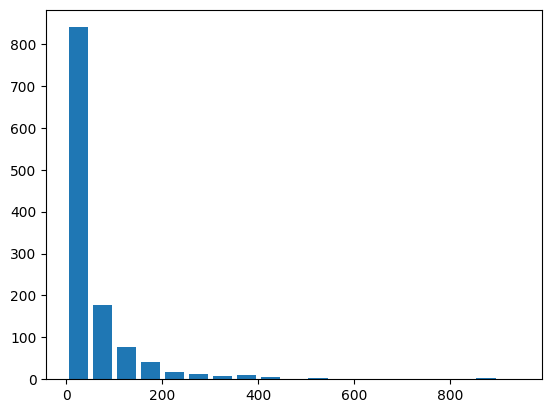

In [50]:
fig, ax = plt.subplots()

ax.hist(knowwho_profiles["N_tweets_leadup"], bins=range(0, 1000, 50), rwidth=0.8);

In [51]:
len(knowwho_profiles[knowwho_profiles["N_tweets_leadup"] > 0])

967

In [52]:
knowwho_profiles[knowwho_profiles["N_tweets_leadup"] > 0]["INCUMBENT"].value_counts()

INCUMBENT
Y    303
Name: count, dtype: int64

In [53]:
knowwho_profiles["PARTY"].value_counts()

PARTY
R    652
D    552
Name: count, dtype: int64

In [54]:
knowwho_profiles["N_tweets_leadup"].mean()

55.470099667774086

In [55]:
knowwho_profiles["N_tweets_leadup"].std()

116.00293774617238

## Power analysis

### Linear mixed-effects model simulations

In [25]:
# define simulation parameters
n_sim = 100  # Number of simulations
alpha = 0.05  # Significance level

# sample sizes
subset = knowwho_profiles[knowwho_profiles["N_tweets_leadup"] > 0]
n_groups = len(subset)
n_incumbents = len(subset[subset["INCUMBENT"] == "Y"])
n_democrats = len(subset[subset["PARTY"] == "D"])

# variance components - from script estimate_variance_factors_pilot_data.ipynb
var_intercept = 0.002295
var_residual = 0.01237839803161637

In [26]:
def simulate_lme(params):
    random_state, beta_T, beta_P, beta_TP = params
    
    n_obs_per_group = subset["N_tweets_leadup"]\
        .sample(n_groups, random_state=random_state)\
        .values.astype(int)
    total_n = n_obs_per_group.sum()

    group = np.repeat(np.arange(n_groups), n_obs_per_group)
    T_group = np.random.binomial(1, n_incumbents / n_groups, n_groups)  # binary predictor T
    P_group = np.random.binomial(1, n_democrats/ n_groups, n_groups)  # binary predictor P
    T_observations = np.repeat(T_group, n_obs_per_group)
    P_observations = np.repeat(P_group, n_obs_per_group)

    random_intercepts = np.random.normal(0, np.sqrt(var_intercept), n_groups)
    random_effects = random_intercepts[group]
    errors = np.random.normal(0, np.sqrt(var_residual), total_n)

    # calculate the dependent variable
    D = (0 + beta_T * T_observations + beta_P * P_observations + \
         beta_TP * T_observations * P_observations + random_effects + errors)
    data = pd.DataFrame({'D': D, 'C': group, 'T': T_observations, 'P': P_observations})

    # fit the linear mixed effects model
    model = smf.mixedlm(
        "D ~ T * P",
        data, 
        groups=data["C"],
    )
    result = model.fit()

    # assess significance of the effects, handle cases where the term is not estimable
    try:
        p_value_interaction = result.pvalues['T:P']
    except KeyError:
        p_value_interaction = np.nan
    try:
        p_value_P = result.pvalues['P']
    except KeyError:
        p_value_P = np.nan
    try:
        p_value_T = result.pvalues['T']
    except KeyError:
        p_value_T = np.nan

    return (random_state, beta_T, beta_P, beta_TP, p_value_T, p_value_P, p_value_interaction)

In [27]:
beta_Ts = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
beta_Ps = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
beta_TPs = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
random_states = range(n_sim)

params = [(i, beta_Ts[j], beta_Ps[j], beta_TPs[j])\
              for j in range(len(beta_Ts))\
              for i in random_states] 
N_configs = len(params)

In [ ]:
results = pd.DataFrame()
pool = Pool(10)

for tmp1, tmp2, tmp3, tmp4, tmp5, tmp6, tmp7 in tqdm(pool.imap_unordered(
    func=simulate_lme, 
    iterable=params), 
    total=N_configs):

    results = pd.concat([results, pd.DataFrame({
        "random_state":[tmp1],
        "beta_T":[tmp2],
        "beta_P":[tmp3],
        "beta_TP":[tmp4],
        "p_value_T":[tmp5],
        "p_value_P":[tmp6],
        "p_value_TP":[tmp7]
    })])

pool.close()

results["alpha"] = alpha
results["var_intercept"] = var_intercept
results["var_residual"] = var_residual
fname = "incumbent_power_analysis.csv"
results.to_csv(Path("../results", fname), index=False)

### Calculate power

In [41]:
# calculate power
results = pd.read_csv("../results/incumbent_power_analysis.csv")
power = pd.DataFrame()

for beta_T, beta_P, beta_TP in zip(beta_Ts, beta_Ps, beta_TPs):
    res = results[
        (results["beta_T"] == beta_T) & \
        (results["beta_P"] == beta_P) & \
        (results["beta_TP"] == beta_TP)
    ]

    power_T = np.nanmean(res["p_value_T"].values < alpha)
    power_P = np.nanmean(res["p_value_P"].values < alpha)
    power_TP = np.nanmean(res["p_value_TP"].values < alpha)
    
    power = pd.concat([power, pd.DataFrame({
        "beta_T":[beta_T],
        "beta_P":[beta_P],
        "beta_TP":[beta_TP],
        "power_T":[power_T],
        "power_P":[power_P],
        "power_TP":[power_TP]
    })])

In [29]:
# calculate power bootstrapped
results = pd.read_csv("../results/incumbent_power_analysis.csv")
power_bootstrap = pd.DataFrame()

n_bootstrap = 100
for beta_T, beta_P, beta_TP in zip(beta_Ts, beta_Ps, beta_TPs):
    for n in range(n_bootstrap):
        res = results[
            (results["beta_T"] == beta_T) & \
            (results["beta_P"] == beta_P) & \
            (results["beta_TP"] == beta_TP)
        ].sample(frac=1, replace=True)
    
        power_T = np.nanmean(res["p_value_T"].values < alpha)
        power_P = np.nanmean(res["p_value_P"].values < alpha)
        power_TP = np.nanmean(res["p_value_TP"].values < alpha)
        
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$T$"],
            "effect":[beta_T],
            "power":[power_T],
        })])
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$P$"],
            "effect":[beta_P],
            "power":[power_P],
        })])
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$T \\times P$"],
            "effect":[beta_TP],
            "power":[power_TP]
        })])

In [30]:
power_bootstrap.head(3)

,variable,effect,power
0,$T$,0.005,0.16
0,$P$,0.005,0.25
0,$T \times P$,0.005,0.02


### Visualisation of power analysis

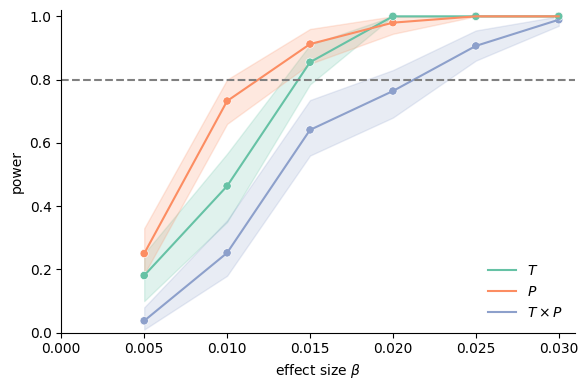

In [31]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=power_bootstrap,
    ax=ax,
    x="effect", 
    y="power",
    hue="variable",
    errorbar="pi",
    palette="Set2",
)

sns.scatterplot(
    data=power_bootstrap.groupby(["variable", "effect"]).mean().reset_index(),
    ax=ax,
    x="effect",
    y="power",
    hue="variable",
    hue_order=["$T$", "$P$", "$T \\times P$"],
    sizes=[50, 50, 50],
    palette="Set2",
    legend=False
)

ax.set_xlabel("effect size $\\beta$")
ax.spines[['right', 'top']].set_visible(False)
ax.legend(frameon=False)
ax.plot([0, 0.031], [0.8, 0.8], '--', color="grey")
ax.set_xlim(0, 0.031)
ax.set_ylim(0, 1.02)
plt.tight_layout()

fname = "power_analysis_incumbent"
dst = "../plots"
plt.savefig(Path(dst, fname + ".pdf"))
plt.savefig(Path(dst, fname + ".svg"))

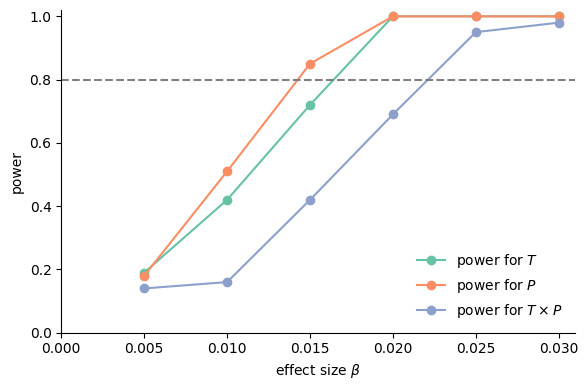

In [46]:
fig, ax = plt.subplots(figsize=(6, 4))
cmap = plt.get_cmap("Set2")

ax.plot(power["beta_T"], power["power_T"], "o-", label="power for $T$", color=cmap.colors[0])
ax.plot(power["beta_T"], power["power_P"], "o-", label="power for $P$", color=cmap.colors[1])
ax.plot(power["beta_T"], power["power_TP"], "o-", label="power for $T \\times P$", color=cmap.colors[2])
ax.set_xlabel("effect size $\\beta$")
ax.set_ylabel("power")

ax.spines[['right', 'top']].set_visible(False)
ax.legend(frameon=False)
ax.plot([0, 0.031], [0.8, 0.8], '--', color="grey")
ax.set_xlim(0, 0.031)
ax.set_ylim(0, 1.02)
plt.tight_layout()

fname = "power_analysis_incumbent"
dst = "../plots"
plt.savefig(Path(dst, fname + ".pdf"))
plt.savefig(Path(dst, fname + ".svg"))

## Main analysis

TODO